<a href="https://colab.research.google.com/github/CTA-MLDS/sentiment-analysis/blob/01062024/data_set_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers datasets

In [ ]:
! pip install fugashi ipadic

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Hugging Face (Transformers) 関連のモジュール
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_metric

In [ ]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json
# jupyter notebookで動くように書き換え↓
# ! pip install matplotlib
# ! pip install japanize-matplotlib

# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
rm: cannot remove '/root/.cache/matplotlib/fontlist-v310.json': No such file or directory


In [ ]:
!sudo apt-get install fonts-ipafont-gothic
!sudo fc-cache -fv
!rm /root/.cache/matplotlib/fontlist-v310.json

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype/ipafont-gothic: caching, new cache contents: 2 fonts, 0 dirs
/usr/share/fonts/opentype/ipafont-mincho: caching, new cache contents: 2 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 2 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/opentype: skipping, looped directory de

In [ ]:
! pip install japanize-matplotlib

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [ ]:
# if 'IPAGothic' not in plt.rcParams['font.family']:
#     plt.rcParams['font.family'] = 'MS Gothic'

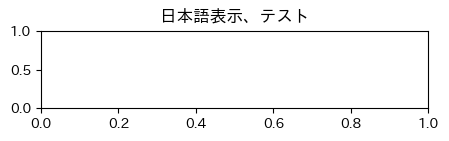

In [ ]:
# 動作確認
plt.figure(figsize=(5, 1))
plt.title('日本語表示、テスト')
plt.show()

In [ ]:
# GitHubよりWRIMEデータをダウンロードする
#
# WRIME dataset : https://github.com/ids-cv/wrime
# 今回使用するのは ver1 （感情極性が付与されていない版）

! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

# question to ask
# tried to run the command through this cell, didn't work.
# installed wget, but couldn't execute the file
# manually moved the file to the system32 file of windows and ran the program through cmd (and worked??)

# fugashiがインストールできない
# -> mecab.hが認識されない -> 通常はincludeサブディレクトリにあるはずだが、代わりにsrcに入っている（そしてincludeは存在していない）
# -> mecabを再度インストール -> mecabのバージョンをチェックしたいmecab --versionが、エラー（'mecab' is not recognized as an internal or external command,
# operable program or batch file.）-> 環境変数にpathを追加 -> INCLUDE変数も追加 -> やっぱりmecab.hが認識されない
# mecabのビルド済みバイナリをインストール　pip install mecab-python-binary　pip install mecab-python3　pip install mecab-python3 --global-option="--with-cflags=-IC:\Users\minaa\OneDrive\TCA\mecab\mecab\mecab\src"
# fugashiを諦めます


--2024-01-16 10:26:12--  https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv [following]
--2024-01-16 10:26:13--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9487235 (9.0M) [text/plain]
Saving to: ‘wrime-ver1.tsv.1’

wrime-ver1.tsv.1    100%[===================>]   9.05M  30.6MB/s    in 0.3s    

2024-01-16 10:26:13 (30.6 MB/s) - ‘wrime-ver1.tsv.1’ saved [9487235/9487235]



In [ ]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0


In [ ]:
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']
num_labels = len(emotion_names)

# objective emotion average (Avg. Readers_*) values are converted to list, defined as a new column
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# removing samples with less emotion intensities
# (max.readers_emotion_intensities must be 2 or more)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [ ]:
# divide into train and test data
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 17104
test : 1133


In [ ]:
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

In [ ]:
#  (1) 使用するモデルをより簡素なものに
# checkpoint = 'distilbert-base-japanese'
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# (2) モデルの一部の層を削減して軽量化
from transformers import AutoModel, AutoConfig
config = AutoConfig.from_pretrained(checkpoint, num_hidden_layers=6)  # 6層に変更
model = AutoModel.from_pretrained(checkpoint, config=config)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
# (3) モデルのEmbedding層の次元を削減
# config = AutoConfig.from_pretrained(checkpoint, hidden_size=252)
# model = AutoModel.from_pretrained(checkpoint, config=config, ignore_mismatched_sizes=True)


Some weights of BertModel were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized because the shapes did not match:
- bert.embeddings.word_embeddings.weight: found shape torch.Size([32000, 768]) in the checkpoint and torch.Size([32000, 252]) in the model instantiated
- bert.embeddings.position_embeddings.weight: found shape torch.Size([512, 768]) in the checkpoint and torch.Size([512, 252]) in the model instantiated
- bert.embeddings.token_type_embeddings.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([2, 252]) in the model instantiated
- bert.embeddings.LayerNorm.weight: found shape torch.Size([768]) in the checkpoint and torch.Size([252]) in the model instantiated
- bert.embeddings.LayerNorm.bias: found shape torch.Size([768]) in the checkpoint and torch.Size([252]) in the model instantiated
- bert.encoder.layer.0.attention.self.query.weight: found shape torch.Size([768, 768]) in the checkp

In [ ]:
import torch

from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_metric

In [ ]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length', return_tensors="pt")
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17104 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [ ]:
# 分類モデルのため AutoModelForSequenceClassification を使用する
# checkpoint と num_labels（クラス数） を指定する. 今回は、いずれも上で定義済み
# - checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# - num_labels = 8
# config = AutoConfig.from_pretrained(checkpoint, num_labels=8)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# AdamWオプティマイザの定義
optimizer = AdamW(model.parameters(), lr=2e-5)  # lrは学習率,これがデフォルト

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def tokenize_batch(batch):
    return tokenizer(batch['Sentence'], truncation=True, padding=True)

In [ ]:
# (1)
#データセット内の各サンプルのSentenceを同じ長さに調整する
# パディングを行うか、あるいはトリミングを行う
max_length = 512  # 調整後の最大長さ

# Sentenceを指定した長さにトリミングする関数
def trim_sentence(sample, tokenizer, max_length):
    # Sentenceをトークン化
    tokens = tokenizer(
        sample['Sentence'],
        max_length=max_length,
        truncation=True,
        padding='max_length'  # パディングもmax_lengthに合わせる
    )
    # トリミング後のトークンを元のフィーチャに反映
    sample['input_ids'] = tokens['input_ids'][:max_length]
    sample['attention_mask'] = tokens['attention_mask'][:max_length]
    sample['labels'] = sample['readers_emotion_intensities']  # labelsを追加
    return sample

# トリミングを適用
trimmed_train_tokenized_dataset = [trim_sentence(sample, tokenizer, max_length) for sample in train_tokenized_dataset]
trimmed_test_tokenized_dataset = [trim_sentence(sample, tokenizer, max_length) for sample in test_tokenized_dataset]


In [ ]:
!pip install accelerate==0.20.3
!pip install transformers[torch] -U

  Using cached accelerate-0.20.3-py3-none-any.whl (227 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.26.1
    Uninstalling accelerate-0.26.1:
      Successfully uninstalled accelerate-0.26.1


  Using cached accelerate-0.26.1-py3-none-any.whl (270 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# 任意のディレクトリ名を指定
directory_name = 'cta'

# Google Drive内にディレクトリを作成
directory_path = os.path.join('/content/drive/MyDrive', directory_name)
os.makedirs(directory_path, exist_ok=True)


In [ ]:
from transformers import get_linear_schedule_with_warmup

# トレーニング時の設定
training_args = TrainingArguments(
    output_dir="directory_path",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=0.8,
    evaluation_strategy="steps",
    eval_steps=200,
    lr_scheduler_type="linear",  # スケジューラのタイプを指定
)

# 学習率のスケジューラの設定
num_training_steps = len(train_tokenized_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)


In [ ]:
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels", None)
        if labels is None:
            raise ValueError("Labels are missing or None in the inputs during training.")
        # モデルのフォワードパス
        outputs = model(**inputs)
        # logitsから損失を計算
        logits = outputs.logits
        loss = nn.CrossEntropyLoss()(logits, labels.view(-1))  # ラベルの形状を変更
        if return_outputs:
            return (loss, outputs)
        else:
            return loss.item() if hasattr(loss, "item") else loss


In [ ]:
# 通常のTrainerと同様の引数を指定して、CustomTrainerを初期化する
custom_trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=trimmed_train_tokenized_dataset,
    eval_dataset=trimmed_test_tokenized_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

torch.cuda.empty_cache()

# 訓練を実行
custom_trainer.train()


ValueError: Expected input batch_size (4) to match target batch_size (32).

このエラーは、期待される入力とターゲットのバッチサイズが一致しないことを示しています。エラーメッセージによると、入力のバッチサイズは4であり、ターゲットのバッチサイズは32です。

この問題を解決するために、次のいくつかの点を確認してみましょう。

データの確認: トレーニングデータとラベルのサイズが正しいか確認してください。特に、データとラベルが正しく結びついていることを確認してください。

データローダーのバッチサイズ: トレーニング中に使用されるデータローダーのバッチサイズが正しいか確認してください。データローダーのバッチサイズは、モデルへの入力とラベルのバッチサイズと一致する必要があります。

損失関数の適用: カスタムの損失関数でnn.CrossEntropyLoss()を使用していますが、この関数は通常、ログオッズ（logits）とクラスラベルのバッチを取ります。ラベルは長さがバッチサイズ分の1次元テンソルである必要があります。エラーメッセージから見ても、ラベルの形状を変更しているようですが、それが正しく行われているか確認してください。

In [ ]:
from torch import nn
from transformers import Trainer, TrainingArguments

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels", None)
        if labels is None:
            raise ValueError("Labels are missing or None in the inputs during training.")
        # モデルのフォワードパス
        outputs = model(**inputs)
        # logitsから損失を計算
        logits = outputs.logits
        # ラベルの形状を変更
        labels = labels.view(-1)
        # バッチサイズが4になるように変更
        logits = logits.view(-1, 4)
        loss = nn.CrossEntropyLoss()(logits, labels)
        if return_outputs:
            return (loss, outputs)
        else:
            return loss.item() if hasattr(loss, "item") else loss

# 以下のように TrainingArguments を設定
args = TrainingArguments(
    output_dir=directory_path,
    per_device_train_batch_size=4,  # 1つのGPUあたりのトレーニングバッチサイズ
    per_device_eval_batch_size=4,   # 1つのGPUあたりの評価バッチサイズ
    gradient_accumulation_steps=1,  # 勾配蓄積のステップ数
    # 他の設定...
    num_train_epochs=0.8,
    evaluation_strategy="steps",
    eval_steps=200,
)

# 訓練データやモデルなどの準備...
# train_dataset, eval_dataset, model, tokenizer の定義...

# Trainerのインスタンスを作成
custom_trainer = CustomTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=trimmed_train_tokenized_dataset,
    eval_dataset=trimmed_test_tokenized_dataset,
)

# 訓練を実行
custom_trainer.train()


ValueError: Expected input batch_size (4) to match target batch_size (32).

In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     # data_collator=pad_collate,  # デフォルトのデータコレーターを使用
#     train_dataset=train_tokenized_dataset,
#     eval_dataset=test_tokenized_dataset,
#     compute_metrics=compute_metrics,
#     # optimizer=optimizer,
#     # lr_scheduler=scheduler,  # 学習率スケジューラを指定
# )

# # 訓練を実行
# trainer.train()

In [ ]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

In [ ]:
analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)


In [ ]:
analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)

In [ ]:
analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)

In [ ]:
analyze_emotion('え、今日って休校だったの？', show_fig=True)


In [ ]:
analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)

In [ ]:
analyze_emotion('あぁー、イライラするっ！！', show_fig=True)